David Diaz

# Final Exam

#### Your objective is to determine if daily ambient air pollution levels are associated with cardiovascular mortality. To do so, you will look at data collected from Los Angeles, CA from 1987 to 1997. The variables associated with the data are listed below and the data are available in “LAdata.csv”. Please consider the following in addressing this objective – based on your findings, what is the most important air pollution predictor of death?  
#### Include a brief introduction (1 – 3 sentences), a methods section (with a written description of the model(s) fit, the modeling approach you took, implementation, diagnostics, model selection, etc.), a results, and a short discussion (3-4 sentences that interprets your findings). Tables and figures are welcome.

### Introduction

Air pollution is increasingly recognized as an relevant driver of human illness, disease, and mortality. In this project, I utilized a Bayesian statistical approach to estimate the relative potential contribution of ambient air pollution levels from four air pollutants (ozone, sulfur dioxide, nitrogen dioxide, and carbon monoxide) on the occurrence of cardiovascular mortality in Los Angeles. This project revisits a portion of the research copmrising the  National Morbidity, Mortality and Air Pollution Study. The primary objective in the report here is identifying which of these four pollutants is the most imporant predictor of cardiovascular mortality.

### Methods

Daily ambient air pollution levels used in this project cover Los Angeles from January 1, 1987 through December 31, 1997 recorded in the Environmental Protection Agency's Aerometric Information Retrieval System (AIRS) and AirData System. Local weather variables (air temperature and relative humidity) were drawn from the National Climatic Data Center EarthInfo CD-ROM. Daily mortality counts are provided by the National Center for Health Statistics.  

Two log-linear Poisson models were evaluated to quantify the relative contributions of these four pollutants to daily observations of cardiovascular mortality  ($Y_t$): $y_t \sim Poisson(\mu_t)$. Season, Month, and Day of Week were treated as indicator variables, with a series of 4, 12, and 7 parameters (as vectors $\mathbf{\beta_1}$, $\mathbf{\beta_2}$, and $\mathbf{\beta_3}$, respectively). All continuous variables were transformed to z-scores, centered around zero by subtracting the mean value and dividing by the standard deviation for modeling. The effect of each pollutant was assumed to be constant throughout this timeframe. Priors were generally selected to reperesent vague/uninformative distributions.

In the first model, the expected mean value of morality, $\mu_t$, was estimated using all available variables: $log(\mu_t) = \mathbf{\beta_1}Season_t + \mathbf{\beta_2}Month_t + \mathbf{\beta_3}DayofWeek_t + \beta_4Temp_t + \beta_5RelHum_t + \alpha_1O_3 + \alpha_2SO_2 + \alpha_3NO_2 + \alpha_4CO$. In the first model, all priors were modeled as Normal distributions with mean of zero and standard deviations of 10 or 20. 

In the second model, parameters for each month were dropped, and a hierarchical modeling approach was used to permit partial pooling of parameters for seasonal and day-of-week effects, which were each drawn from distributions shared among seasons, and days-of-the-week, respectively. Hyperparameters for these pooled distributions were modeled with normally distributed means and uniformly distributed standard deviations.

The posterior distributions for all model parameters were estimated using Markov Chain Monte Carlo (MCMC) simulation implemented using the PyMC3 package within the Python programming language. Each model was simulated with two MCMC chains, and convergence of model parameters was evaluated using the Gelman-Rubin $\hat R$ statistic. Model fit and parsimony were compared using the Deviation Information Criterion and Watanabe-Aikaike Information Criterion. All code for implementing this analysis is shown below, and is published on GitHub at https://github.com/d-diaz/SEFS590F_Winter2017/blob/master/SEFS%20590F%20(Bayesian%20Models)%20-%20Final%20Exam.ipynb.

### Results

For both models, convergence was achieved for temperature, humidity, and all pollutant parameters (with values of $\hat R$ at or near 1 and with both chains visually oscillating without long-term drift or apparent autocorrelation). While some parameter estimates for individual months appeared to converge in Model 1 (fall months had values of $\hat R$ <1.5), neither model successfully provided converged estimates for all seasons, months, or days of the week. For all of these time-related variables, the two MCMC chains persisted separately, without converging to a single shared distribution, suggesting poor model design to adequately capture the relevant structure of the data-generating processes.

Between these two models, model 2 was selected to estimate the relative contribution of air pollutants to cardiovascular mortality based on lower values for DIC and WAIC, including a lower effective number of parameters estimated through WAIC. The estimated effect of each pollutant is graphed immediatley below, with full listing of model parameters for Model 2 are shown in the table following these graphs. Pollutants 0, 1, 2, and 3 refer to ozone, sulfur dioxide, nitrogen dioxide, and carbon monoxide, respectively.  Based on the mean and credible intervals for these z-scored pollutant concentrations, I conclude that carbon monoxide makes the strongest positive contribution to observed cardiovascular mortality, with nitrogen dioxide close behind. Curiously, ozone levels were significantly negatively correlated with cardiovascular mortality. 

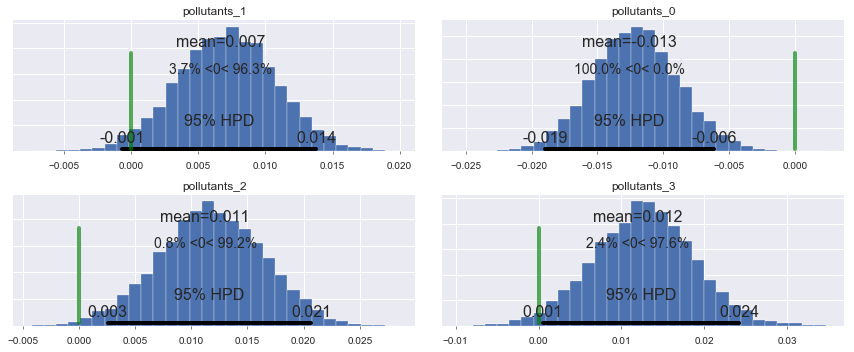

In [101]:
pm.plot_posterior(hier_trace[1000:], varnames=['pollutants'], ref_val=0);

In [98]:
pm.df_summary(hier_trace[1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
seasons_mu,2.065084,0.648697,0.061402,1.340796,2.827827
dayofweek_mu,2.180919,0.617326,0.061726,1.512196,2.838416
temp,-0.031412,0.003072,0.000076,-0.037452,-0.025326
relhum,-0.021737,0.002094,0.000038,-0.025885,-0.017699
pollutants__0,-0.012598,0.003292,0.000106,-0.018992,-0.006146
pollutants__1,0.006660,0.003677,0.000134,-0.000705,0.013777
pollutants__2,0.011236,0.004647,0.000195,0.002566,0.020663
pollutants__3,0.011947,0.006078,0.000287,0.000508,0.024188
seasons__0,2.177288,0.617372,0.061733,1.519861,2.844956
seasons__1,2.078908,0.617364,0.061733,1.422993,2.747237


## HOW THE SAUSAGE WAS MADE

In [14]:
# core packages for data analysis
import numpy as np, pandas as pd
import pymc3 as pm
import scipy as sp

In [15]:
from matplotlib import pyplot as plt # core graphing
import seaborn as sns # pretty graphing
%matplotlib inline

### Section 1 - Data Exploration

In [16]:
data = pd.read_csv('LAData.csv')

In [17]:
data.head()

,Date,Month,Day of week,season,Deaths,Temp,RelHumid,O3,SO2,NO2,CO
0,1/1/1987,1,5,1,96,57.0000,88.1250,-16.0073,2.8412,26.3063,2436.2
1,1/2/1987,1,6,1,107,57.6250,84.5625,-11.6595,1.1812,27.8281,2011.5
2,1/3/1987,1,7,1,99,58.3750,83.0625,-10.3241,1.1416,11.1614,1215.5
3,1/4/1987,1,1,1,93,54.8750,84.5625,-18.6471,-3.0086,-12.3531,-767.8
4,1/5/1987,1,2,1,97,54.6875,65.1250,-17.5291,-1.4868,-10.2597,145.7


In [18]:
data['Date'] =  pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [19]:
data['Day'] = (data.Date - data.Date[0]).astype('timedelta64[D]')

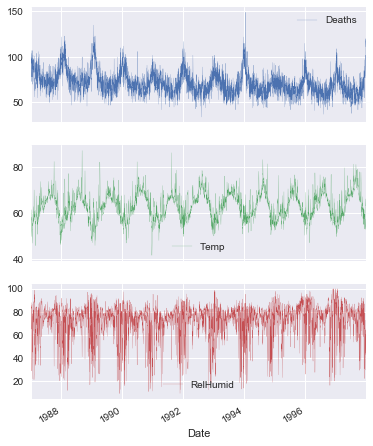

In [20]:
data.plot(x='Date', y=['Deaths', 'Temp', 'RelHumid'], linewidth=0.2, subplots=True, figsize=(6, 8));

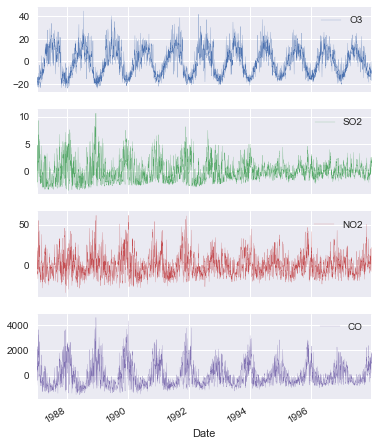

In [21]:
data.plot(x='Date', y=['O3', 'SO2', 'NO2', 'CO'], linewidth=0.2, subplots=True, figsize=(6, 8));

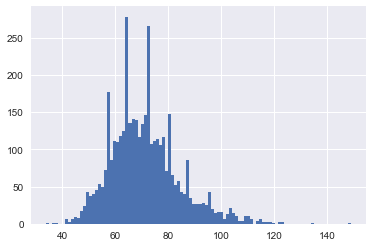

In [22]:
data.Deaths.hist(bins=100);

In [23]:
from pandas.tools.plotting import scatter_matrix

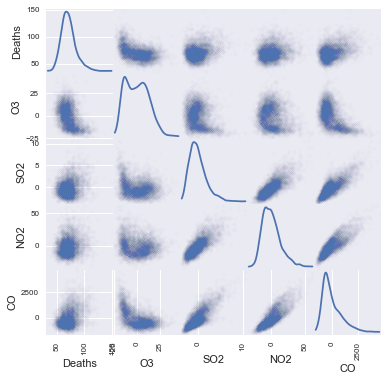

In [24]:
scatter_cols = ['Deaths', 'O3', 'SO2', 'NO2', 'CO']
scatter_matrix(data[scatter_cols], alpha=0.01, figsize=(6, 6), diagonal='kde');

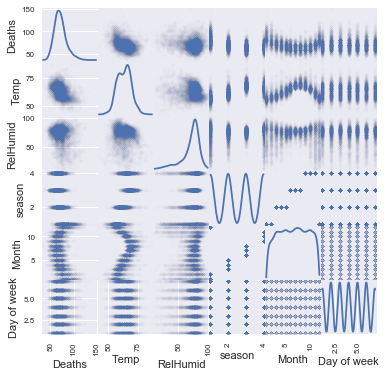

In [25]:
scatter_cols = ['Deaths', 'Temp', 'RelHumid', 'season', 'Month', 'Day of week']
scatter_matrix(data[scatter_cols], alpha=0.01, figsize=(6, 6), diagonal='kde');

### Section 2 - Modest Data Munging

In [26]:
Date = data.Date
Season = data.season
Month = data.Month
DayWeek = data['Day of week']
deaths = data.Deaths

To facilitate MCMC sampling, we'll transform all continuous covariates to z-scores. Temperature and Relative humidity values are still raw values, but pollutant levels came already centered with mean=0.

In [27]:
Temp = data.zTemp = (data.Temp - data.Temp.mean())/data.Temp.std()
RelHum = data.zRelHum = (data.RelHumid - data.RelHumid.mean())/data.RelHumid.std()
O3 = data.zO3 = data.O3/data.O3.std()
SO2 = data.zSO2 = data.SO2/data.SO2.std()
NO2 = data.zNO2 = data.NO2/data.NO2.std()
CO = data.zCO = data.CO/data.CO.std()

In [28]:
# we'll use indexes to estimate parameters for each season, month, and day of week
# -1 used so that indexing list of params starts at 0
season_idx = data.season.values-1
month_idx = data.Month.values-1
dayweek_idx = DayWeek.values-1

In [29]:
num_obs = len(deaths)

### Section 3 - Bayesian Modeling

#### Model 1: Basic Linear Model
$y_t \sim Poisson(\mu_t)$  
$log(\mu_t) = \mathbf{\beta_1}Season_t + \mathbf{\beta_2}Month_t + \mathbf{\beta_3}DayofWeek_t + \beta_4Temp_t + \beta_5RelHum_t + \alpha_1O_3 + \alpha_2SO_2 + \alpha_3NO_2 + \alpha_4CO$

In [44]:
with pm.Model() as pollutant_model:
    
    # priors for unknown model parameters
    b1 = pm.Normal('seasons', mu=0, sd=20, shape=4)
    b2 = pm.Normal('months', mu=0, sd=20, shape=12)
    b3 = pm.Normal('daysofweek', mu=0, sd=20, shape=7)
    b4 = pm.Normal('temp', mu=0, sd=10)
    b5 = pm.Normal('relhumid', mu=0, sd=10)
    a = pm.Normal('pollutants', mu=0, sd=10, shape=4)
        
    # Expected Value of Deaths
    mu_t = pm.math.exp(b1[season_idx] + b2[month_idx] + b3[dayweek_idx] \
                + b4*Temp + b5*RelHum + a[0]*O3 + a[1]*SO2 + a[2]*NO2 + a[3]*CO)
    # use of indexes here reaches into the relevant parameter for each variable
    # e.g., b1[season_idx] will index into the four estimated params for b1
    # based on the value of the season (0-3)
    
    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=mu_t, observed=deaths)

In [45]:
# hit the inference button
with pollutant_model:
    # draw a trace with 25,000 posterior samples
    # running chains in parallel with njobs>1 seems to hang
    # so running chains in sequence instead
    trace = pm.backends.base.merge_traces([pm.sample(25000, step=pm.Metropolis(), 
                    chain=i, progressbar=True) for i in range(2)])


100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:15<00:00, 184.99it/s]


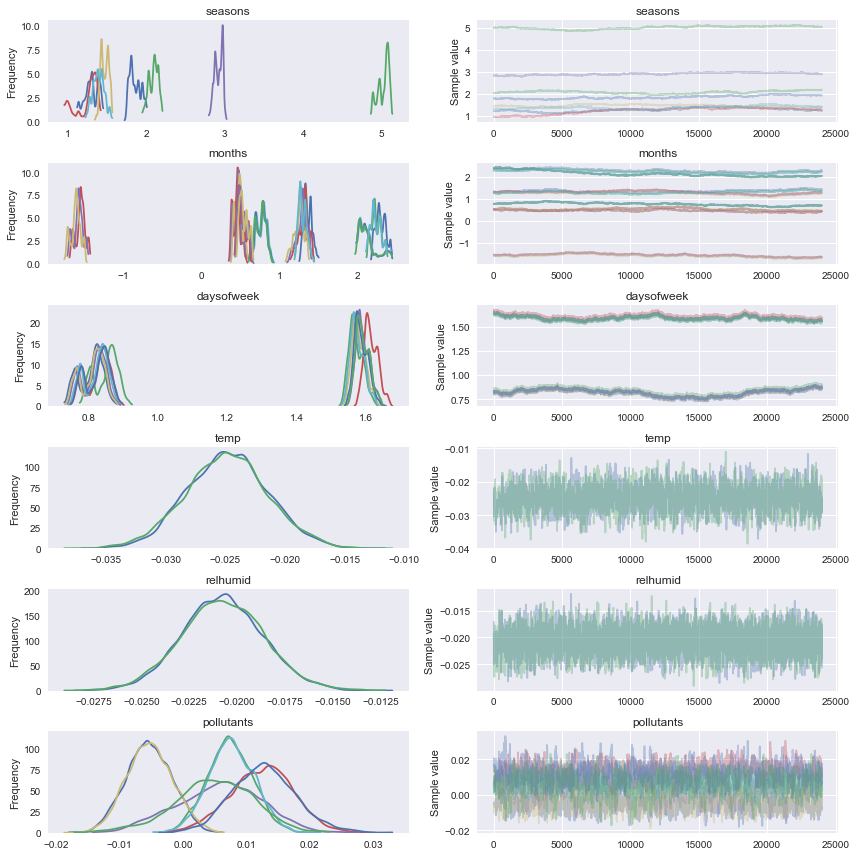

In [46]:
plt.figure()
pm.traceplot(trace[1000:])
plt.tight_layout()

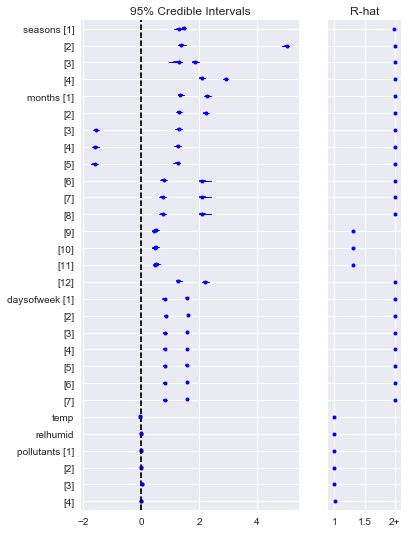

In [47]:
with pollutant_model:
    plt.figure(figsize=(6,8))
    pm.forestplot(trace[1000:])

Visual inspection of chains and Gelman-Rubin $\hat R$ values indicate several parameters are struggling to converge, most notably those for seasons ($\mathbf{\beta_1}$), months ($\mathbf{\beta_2}$), and days of week ($\mathbf{\beta_3}$). Although they haven't converged, the monthly, daily, and seasonal parameters appear to be clustering into groups, suggesting a hierarchical model that pools these parameters would be worth investigating.

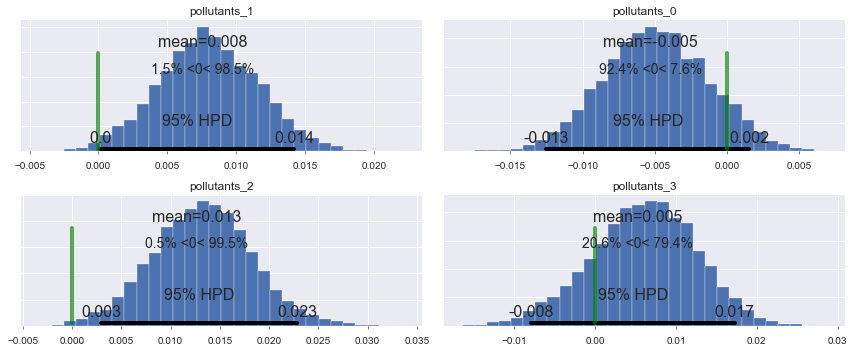

In [48]:
# generate histograms of posterior predictive distributions with  
# 95% highest posterior density intervals and reference line at 0
with pollutant_model:
    # pollutant parameters
    pm.plot_posterior(trace[1000:], varnames=['pollutants'], ref_val=0)

In [54]:
# statistical assessments of model predictive ability
with pollutant_model:
    pollutant_dic = pm.stats.dic(trace[1000:])
    pollutant_waic = pm.stats.waic(trace[1000:], n_eff=True)

30704.4394264 (30498.78786021113, 143.39921168175391, 36.761441403759832)


In [61]:
print('DIC:', pollutant_dic)
print('WAIC:', pollutant_waic[0],';', 'Effective # params:', pollutant_waic[2])

DIC: 30704.4394264
WAIC: 30498.7878602 ; Effective # params: 36.7614414038


In [89]:
# dropping season, with expectation that pooling of month parameters
# will capture seasonal effects
with pm.Model() as hier_model:
    
    # priors for unknown model parameters
    # priors for unknown model parameters
    b1_mu = pm.Normal('seasons_mu', mu=0, sd=20)
    b1_sd = pm.Uniform('seasons_sd', lower=0, upper=5)
    b3_mu = pm.Normal('dayofweek_mu', mu=0, sd=20)
    b3_sd = pm.Uniform('dayofweek_sd', lower=0, upper=5)
    b4 = pm.Normal('temp', mu=0, sd=10)
    b5 = pm.Normal('relhum', mu=0, sd=10)
    a = pm.Normal('pollutants', mu=0, sd=10, shape=4)

    b1 = pm.Normal('seasons', mu=b1_mu, sd=b1_sd, shape=4)
    b3 = pm.Normal('dayofweek', mu=b3_mu, sd=b3_sd, shape=7)    
       
    # Expected Value of Deaths
    mu_t = pm.math.exp(b1[season_idx] + b3[dayweek_idx] + b4*Temp + b5*RelHum \
                       + a[0]*O3 + a[1]*SO2 + a[2]*NO2 + a[3]*CO)
    
    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=mu_t, observed=deaths)

In [90]:
# hit the inference button
with hier_model:
    # draw a trace with 25,000 posterior samples
    hier_trace = pm.backends.base.merge_traces([pm.sample(25000, step=pm.Metropolis(), 
                    chain=i, progressbar=True) for i in range(2)])

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:02<00:00, 203.43it/s]


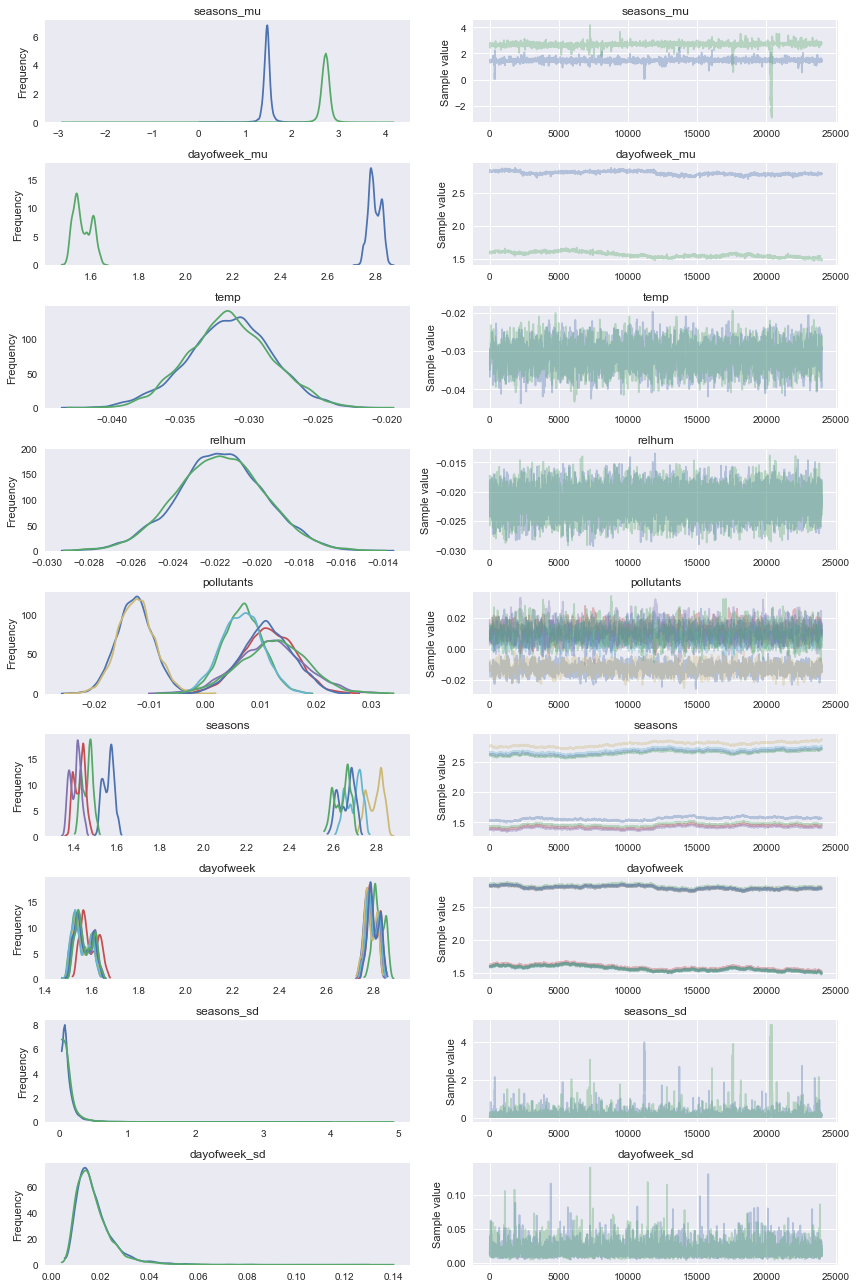

In [91]:
with hier_model:
    plt.figure()
    pm.traceplot(hier_trace[1000:])
    plt.tight_layout()

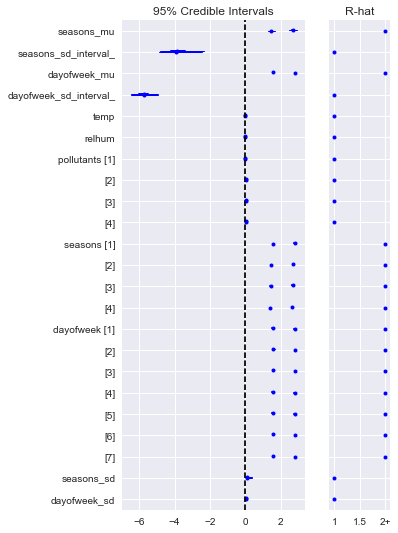

In [92]:
with hier_model:
    plt.figure(figsize=(6,8))
    pm.forestplot(hier_trace[1000:])

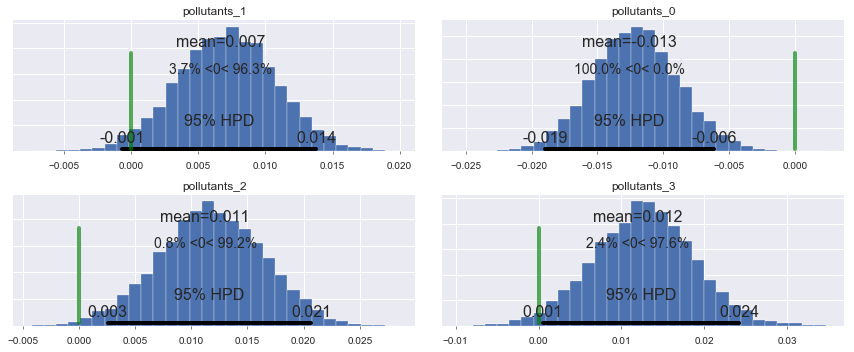

In [93]:
# generate histograms of posterior predictive distributions with  
# 95% highest posterior density intervals and reference line at 0
with hier_model:
    # pollutant parameters
    pm.plot_posterior(hier_trace[1000:], varnames=['pollutants'], ref_val=0)

In [95]:
with hier_model:
    hier_dic = pm.stats.dic(hier_trace[1000:])
    hier_waic = pm.stats.waic(hier_trace[1000:], n_eff=True)

In [96]:
print('DIC:', hier_dic)
print('WAIC:', hier_waic[0],';', 'Effective # params:', hier_waic[2])

DIC: 30610.2233714
WAIC: 30587.8536884 ; Effective # params: 24.8048403509
